# CNN bot for Rock, Paper, Scissors

In this notebook I'm describing a CNN based bot for RPS. <br>
As of right now, the best version of the bot steadily scores >850 on a lb and seems it still has some room for improvement. <br>

## Main ideas:
1. History of bot and opponent actions can be represented as [2, N] tensor.
2. CNN can be trained to predict probabilities of action given game history.

## Algorithm steps:

1. First 11 rounds bot plays randomly as a warm up.
2. Bot keeps track of its own and opponent actions.
3. 10 latest actions starting from one but last are stacked in [2, 10] tensor and are used as an input for CNN (shaded on a figure below). 
4. Winning action in the last round is used as the target.
5. Cross-entropy with soft labels is used to calculate loss. 
6. CNN is updated with single training sample every step.
7. CNN is updated with mini-batch every 10 steps, mini-batch is sampled randomly from the historical data.

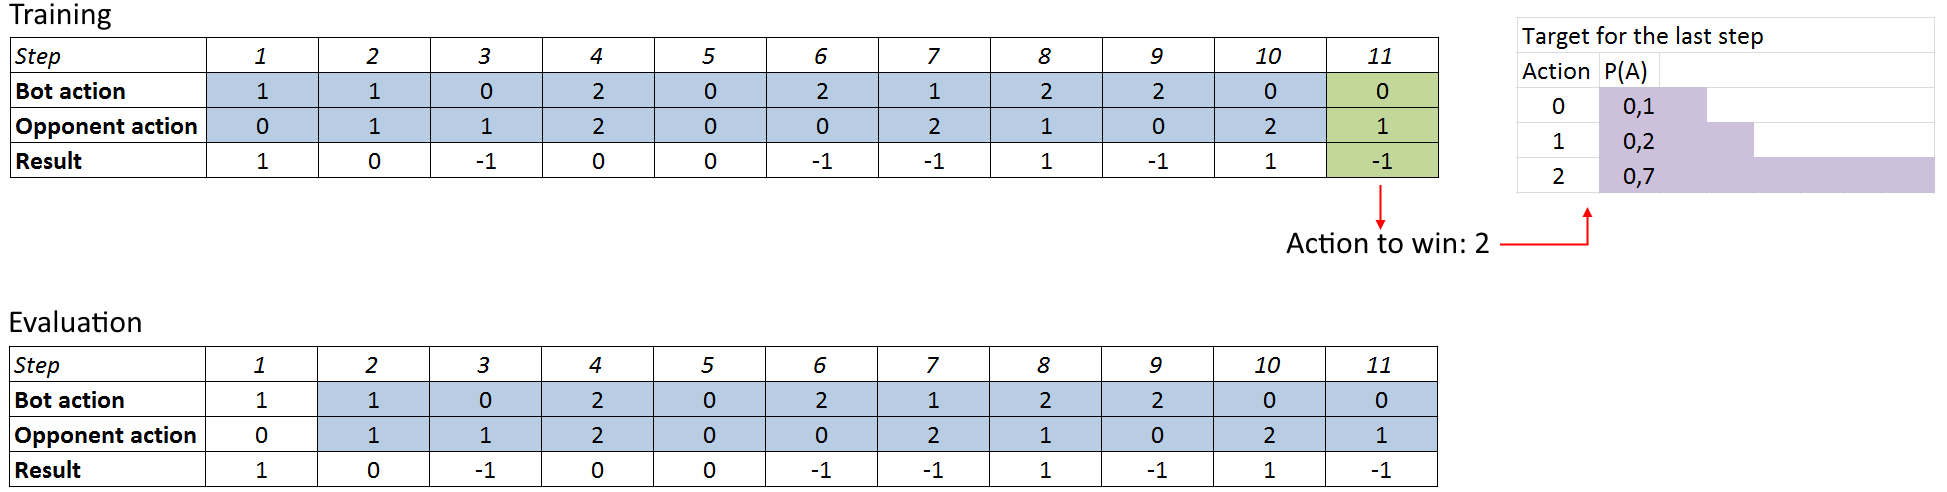

In [ ]:
import numpy as np

import torch
from torch import nn, optim

from kaggle_environments import evaluate, make, utils
from kaggle_environments.envs.rps.utils import get_score
from kaggle_environments.envs.rps.agents import *

## CNN model:

In [ ]:
class RPS(nn.Module):
    """
    Class that predict logits of action probabilities given game history.
        Inputs: game history [bs, 2, 10].
        Outputs: logits of action probabilities [bs, 3].
    """
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(2, 4, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(4, 8, 3, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2),
            nn.Conv1d(8, 16, 2, 1, 1, bias=False),
            nn.ReLU(),
            nn.AvgPool1d(2)
        )
        self.head = nn.Sequential(
            nn.Linear(16, 6),
            nn.ReLU(),
            nn.Linear(6, 3)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x

It seems to me that soft labels perform better than hard labels. <br>
I suppose the reason is that model is less penalized for not winning action, as a result it performs not optimal actions more often, which adds stochastisity to the model and it becomes less predictable for the opponent. <br>
Thus the model balances between winning strategy and stochasticity.

In [ ]:
def soft_cross_entropy(target, prediciton):
    log_probs = nn.functional.log_softmax(prediciton, dim=1)
    sce = -(target * log_probs).sum() / target.shape[0]
    return sce

In [ ]:
def train_step(model, data, optimizer):
    model.train()
    torch.set_grad_enabled(True)

    X = data['X'].view(-1, 2, 10)
    y = data['y'].view(-1, 3)
    prd = model(X)
    loss = soft_cross_entropy(y, prd)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Bot:

In [ ]:
bs = 6 # batch size  

opponent_actions = []
agent_actions = []
actions = []
batch_x = []
batch_y = []


def agent(observation, configuration):
    
    global actions, agent_actions, opponent_actions
    global model, optimizer
    global batch_x, batch_y
    global bs
    
    # first step
    if observation.step == 0:
        hand = np.random.randint(2)
        actions.append(hand)
        return hand
    
    # first warm up rounds
    if 0 < observation.step < 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        hand = np.random.randint(2)
        actions.append(hand)
        return hand
    
    # start to train CNN
    elif observation.step >= 12:
        opponent_actions.append(observation.lastOpponentAction)
        agent_actions.append(actions[-1])
        
        wining_action = (opponent_actions[-1] + 1) % 3 
        fair_action = opponent_actions[-1]
        lose_action = (opponent_actions[-1] - 1) % 3 

        # soft labels for target    
        y = [0, 0, 0]
        y[wining_action] = 0.7
        y[fair_action] = 0.2
        y[lose_action] = 0.1 
        
        # add data for history
        batch_x.append([opponent_actions[-2:-12:-1],
                        agent_actions[-2:-12:-1]])
        batch_y.append(y)
        
        # data for single CNN update 
        data = {'X': torch.Tensor([opponent_actions[-2:-12:-1],
                                   agent_actions[-2:-12:-1]]),
                'y': torch.Tensor(y)} 
        
        # evaluate single training step
        train_step(model, data, optimizer)
        
        # evaluate mini-batch training steps
        if observation.step % 10 == 0:
            k = 1 if observation.step < 100 else 3
            for _ in range(k):
                idxs = np.random.choice(list(range(len(batch_y))), bs)
                data = {'X': torch.Tensor(np.array(batch_x)[idxs]),
                        'y': torch.Tensor(np.array(batch_y)[idxs])}
                train_step(model, data, optimizer)
        
        # data for current action prediction
        X_prd = torch.Tensor([opponent_actions[-1:-11:-1],
                              agent_actions[-1:-11:-1]]).view(1, 2, -1)
        
        # predict logits
        probs = model(X_prd).view(3)
        # calculate probabilities
        probs = nn.functional.softmax(probs, dim=0).detach().cpu().numpy()
        
        # choose action
        hand = np.random.choice([0, 1, 2], p=probs)
        actions.append(hand)
        
        return int(hand)

## Test fight:

In [ ]:
env = make('rps', configuration={"episodeSteps": 1000}, debug=True)

model = RPS()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

env.reset()
env.run([agent, rock])
env.render(mode='ipython', width=500, height=500)

### Few additional bots for the test fight:

In [ ]:
def random_agent(observation, configuration):
    hand = np.random.randint(3)
    return hand

In [ ]:
my_last_action = 0

def hit_the_last_own_action(observation, configuration):
    global my_last_action
    my_last_action = (my_last_action + 1) % 3
    return my_last_action

## Fight club:
Test CNN bot on different opponents.

In [ ]:
def fight(agent, opponents, n_fights=3):
    for opponent_name in opponents.keys():
        scores = []
        wins = 0
        for _ in range(n_fights):
        # reinitialize agent
            model = RPS()
            optimizer = optim.Adam(model.parameters(), lr=1e-3) 

            opponent_agent = opponents[opponent_name]
            score = evaluate('rps', [agent, opponent_agent], configuration={'episodeSteps': 1000})
            agent_score = score[0][0]
            scores.append(agent_score)
            if agent_score > 0:
                wins += 1
        
        print('='*20)
        print(f'Opponent: {opponent_name}')
        print(f'Wins rate: {wins/n_fights*100:.0f}% mean score: {np.mean(scores):.0f}')

In [ ]:
opponents = {
    "rock": rock,
    "paper": paper,
    "scissors": scissors,
    "copy_opponent": copy_opponent,
    "reactionary": reactionary,
    "counter_reactionary": counter_reactionary,
    "statistical": statistical,
    "random": random_agent,
    "hit_the_last_own_action": hit_the_last_own_action
}

In [ ]:
fight(agent, opponents, n_fights=3)

CNN bot is steadily beats some of the basic agents, slightly tuned version performs well on a lb. <br>
Such a model is sensetive to a hyperparameters. <br>
There are a lot of options to experiment with, like CNN arcitecture, optimizer, training cheme, etc.